In [11]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

In [12]:
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.models import Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge
from keras.datasets import imdb

In [13]:
max_features = 2000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=max_features,
                                                      test_split=0.2)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

Loading data...
20000 train sequences
5000 test sequences
Pad sequences (samples x time)
X_train shape: (20000, 80)
X_test shape: (5000, 80)


In [14]:
X_train[0]

array([ 360,    7,   19,  396,   17,   26,  269,  929,   18, 1769,  493,
          6,  116,    7,  105,    5,  575,  182,   27,    5, 1002, 1085,
        130,   62,   17,   24,   89,   17,   13,  381, 1421,    8,    2,
          7,    5,    2,   38,  325,    7,   17,   23,   93,    9,  156,
        252,   19,  235,   20,   28,    5,  104,   76,    7,   17,  169,
         35,    2,   17,   23, 1460,    7,   36,    2,  934,   56,    2,
          6,   17,  891,  214,   11,    5, 1552,    6,   92,    6,   33,
        256,   82,    7], dtype=int32)

In [15]:
X_train[1000]

array([ 56,   2, 157,   7, 275,   5, 219, 604,  10,   2,   5,   2, 164,
        24,  36, 760, 214,  11, 115,  86,   2,  75,  11,  20,   7, 730,
       267,  13, 257,   5, 718, 265, 761,  19,  40, 143, 129,   6,   8,
        21,  13, 671, 162,   7,   2,   6, 102,  10, 918,  23, 185, 431,
         2,   6,  19,  40,  11, 412,   2,  68,  19,  40, 179,  67,  11,
       153,  58,  20,   2,   2, 761,   7, 835,   6,   2, 146, 447,  18,
       902,   7], dtype=int32)

## LSTM

In [16]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen, dropout=0.2))
model.add(LSTM(128, dropout_W=0.2, dropout_U=0.2))  # try using a GRU instead, for fun
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Build model...
____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
embedding_4 (Embedding)            (None, 80, 128)     256000      embedding_input_2[0][0]          
____________________________________________________________________________________________________
lstm_6 (LSTM)                      (None, 128)         131584      embedding_4[0][0]                
____________________________________________________________________________________________________
dense_4 (Dense)                    (None, 1)           129         lstm_6[0][0]                     
____________________________________________________________________________________________________
activation_2 (Activation)          (None, 1)           0           dense_4[0][0]                    
Total params: 387713
_______________________________________________________

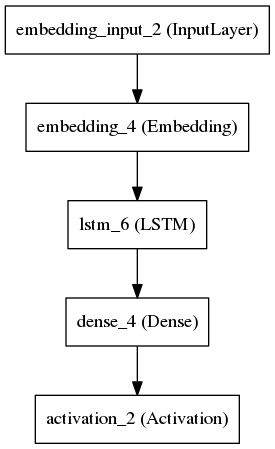

In [17]:
from IPython.display import Image
from keras.utils.visualize_util import plot

plot(model, to_file='model.png')
Image('model.png')

## Bidi LSTM

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_6 (InputLayer)               (None, 80)          0                                            
____________________________________________________________________________________________________
embedding_8 (Embedding)            (None, 80, 128)     256000      input_6[0][0]                    
____________________________________________________________________________________________________
lstm_13 (LSTM)                     (None, 64)          49408       embedding_8[0][0]                
____________________________________________________________________________________________________
lstm_14 (LSTM)                     (None, 64)          49408       embedding_8[0][0]                
___________________________________________________________________________________________

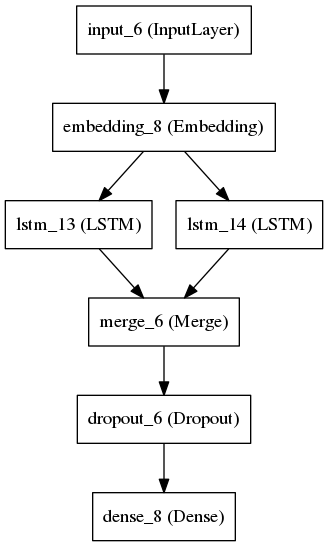

In [23]:
# this is the placeholder tensor for the input sequences
sequence = Input(shape=(maxlen,), dtype='int32')
# this embedding layer will transform the sequences of integers
# into vectors of size 128
embedded = Embedding(max_features, 128, input_length=maxlen)(sequence)

# apply forwards LSTM
forwards = LSTM(64)(embedded)
# apply backwards LSTM
backwards = LSTM(64, go_backwards=True)(embedded)

# concatenate the outputs of the 2 LSTMs
merged = merge([forwards, backwards], mode='concat', concat_axis=-1)
after_dp = Dropout(0.5)(merged)
output = Dense(1, activation='sigmoid')(after_dp)

model = Model(input=sequence, output=output)

print(model.summary())

plot(model, to_file='model.png')
Image('model.png')

In [18]:
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
print(X_train.shape)
print(y_train.shape)
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=15,
          validation_data=(X_test, y_test))
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)


Train...
(20000, 80)
(20000,)
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 1120, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 301, in wrapped
    return f(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 364, in _fixed_getinnerframes
    lines = ulinecache.getlines(file)[start:end]
KeyboardInterrupt


ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



IndexError: string index out of range

In [ ]:
print(score, acc)